# Fake News Detection - Phase 4: Deep Learning Models

---

### Objectifs de ce notebook
Construire un modele BiLSTM avec preprocessing optimise pour le deep learning.

**Architecture** :
- Embeddings : Word2Vec Google News (300d)
- BiLSTM simple (baseline)
- Regularisation (Dropout, Early Stopping)
- Explainability avec LIME

---

## Section 1 : Setup et Installation

In [ ]:
import torch
torch.cuda.is_available()


True

In [ ]:
!pip install --upgrade --no-cache-dir gensim scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 222.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 226.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


In [ ]:
!pip install -q lime==0.2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Imports standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

# NLTK pour tokenization basique
import nltk
nltk.download('punkt', quiet=True)
from nltk.tokenize import word_tokenize

# Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Word Embeddings
import gensim.downloader as api

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Explainability
from lime.lime_text import LimeTextExplainer

# Seed pour reproductibilite
np.random.seed(42)
tf.random.set_seed(42)

print("Imports termines !")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

Imports termines !
TensorFlow version: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Montage Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive monte avec succes !")

Mounted at /content/drive
Google Drive monte avec succes !


---

## Section 2 : Chargement des Donnees Brutes

Chargement des fichiers bruts :
- True.csv : Articles authentiques (Reuters)
- Fake.csv : Articles fake news

In [ ]:
# Chemins vers les donnees brutes
true_path = '/content/drive/My Drive/data/True.csv'
fake_path = '/content/drive/My Drive/data/Fake.csv'

# Chargement
print("Chargement des donnees brutes...")
true_df = pd.read_csv(true_path)
fake_df = pd.read_csv(fake_path)

print(f"\nDonnees chargees :")
print(f"   True news : {len(true_df):,} articles")
print(f"   Fake news : {len(fake_df):,} articles")
print(f"   Total     : {len(true_df) + len(fake_df):,} articles")

# Apercu des colonnes
print(f"\nColonnes True.csv : {true_df.columns.tolist()}")
print(f"Colonnes Fake.csv : {fake_df.columns.tolist()}")

Chargement des donnees brutes...

Donnees chargees :
   True news : 21,417 articles
   Fake news : 23,481 articles
   Total     : 44,898 articles

Colonnes True.csv : ['title', 'text', 'subject', 'date']
Colonnes Fake.csv : ['title', 'text', 'subject', 'date']


In [ ]:
# Ajout des labels
true_df['label'] = 1  # Real news = 1
fake_df['label'] = 0  # Fake news = 0

# Concatenation
df = pd.concat([true_df, fake_df], ignore_index=True)

print(f"Dataset combine : {len(df):,} articles")
print(f"\nDistribution :")
print(df['label'].value_counts())

# Apercu
print("\nApercu des donnees :")
df.head()

Dataset combine : 44,898 articles

Distribution :
label
0    23481
1    21417
Name: count, dtype: int64

Apercu des donnees :


title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1

In [ ]:
# Fusion title + text (comme votre equipe)
df['combined_text'] = df['title'].astype(str) + " " + df['text'].astype(str)

print("Colonnes 'title' et 'text' fusionnees dans 'combined_text'")
print(f"\nExemple de texte combine :")
print(df['combined_text'].iloc[0][:500] + "...")

Colonnes 'title' et 'text' fusionnees dans 'combined_text'

Exemple de texte combine :
As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which la...


---

## Section 3 : Preprocessing Optimal pour BiLSTM

**Preprocessing pour BiLSTM** :

Le BiLSTM a besoin de CONTEXTE et de PATTERNS STYLISTIQUES. Contrairement aux modeles ML classiques (TF-IDF), on va :

**CE QU'ON VA FAIRE** :
- Lowercase (uniformisation)
- Suppression URLs (pas de signal utile)
- Suppression mentions/hashtags (artefacts)
- Suppression chiffres isoles (dates, nombres)
- Suppression espaces multiples

**CE QU'ON NE PAS FAIRE** :
- PAS de suppression stopwords ("not", "no" sont critiques !)
- PAS de suppression ponctuation ("!" "?" indiquent le style)
- PAS de lemmatisation ("running" vs "run" a un sens)
- PAS de stemming

In [ ]:
def preprocess_for_bilstm(text):
    """
    Preprocessing OPTIMAL pour BiLSTM.

    On garde PLUS d'information que pour le ML classique :
    - Stopwords : importantes pour le contexte ("not bad" vs "bad")
    - Ponctuation : indicateur de style ("!!!" dans fake news sensationnalistes)
    - Forme originale des mots : nuances semantiques
    """
    # Conversion en string
    text = str(text)

    # Lowercase
    text = text.lower()

    # Suppression URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Suppression mentions et hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Suppression des chiffres isoles (mais on garde la ponctuation !)
    text = re.sub(r'\b\d+\b', '', text)

    # Suppression espaces multiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

print("Fonction de preprocessing definie.")
print("\nExemple AVANT preprocessing :")
sample_text = df['combined_text'].iloc[0][:200]
print(sample_text)
print("\nExemple APRES preprocessing :")
print(preprocess_for_bilstm(sample_text))

Fonction de preprocessing definie.

Exemple AVANT preprocessing :
As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of

Exemple APRES preprocessing :
as u.s. budget fight looms, republicans flip their fiscal script washington (reuters) - the head of a conservative republican faction in the u.s. congress, who voted this month for a huge expansion of


In [ ]:
# Application du preprocessing
print("Application du preprocessing sur tout le dataset...")
print("Cela peut prendre 1-2 minutes...")

df['processed_text'] = df['combined_text'].apply(preprocess_for_bilstm)

print("\nPreprocessing termine !")

# Statistiques de longueur
df['text_length_chars'] = df['processed_text'].apply(len)
df['text_length_words'] = df['processed_text'].apply(lambda x: len(x.split()))

print("\nStatistiques de longueur (en mots) :")
print(df['text_length_words'].describe())

Application du preprocessing sur tout le dataset...
Cela peut prendre 1-2 minutes...

Preprocessing termine !

Statistiques de longueur (en mots) :
count    44898.000000
mean       415.262484
std        349.655233
min          0.000000
25%        214.000000
50%        372.000000
75%        523.000000
max       8110.000000
Name: text_length_words, dtype: float64


### Analyse des Distributions de Longueur

La distribution des longueurs de texte présente une asymétrie à droite, avec une moyenne de 415 mots et une médiane de 372. Cette hétérogénéité pose un défi pour les modèles séquentiels tels que le BiLSTM. Une longueur maximale de 500 tokens a été retenue afin de capturer la majorité des documents tout en limitant le padding excessif.


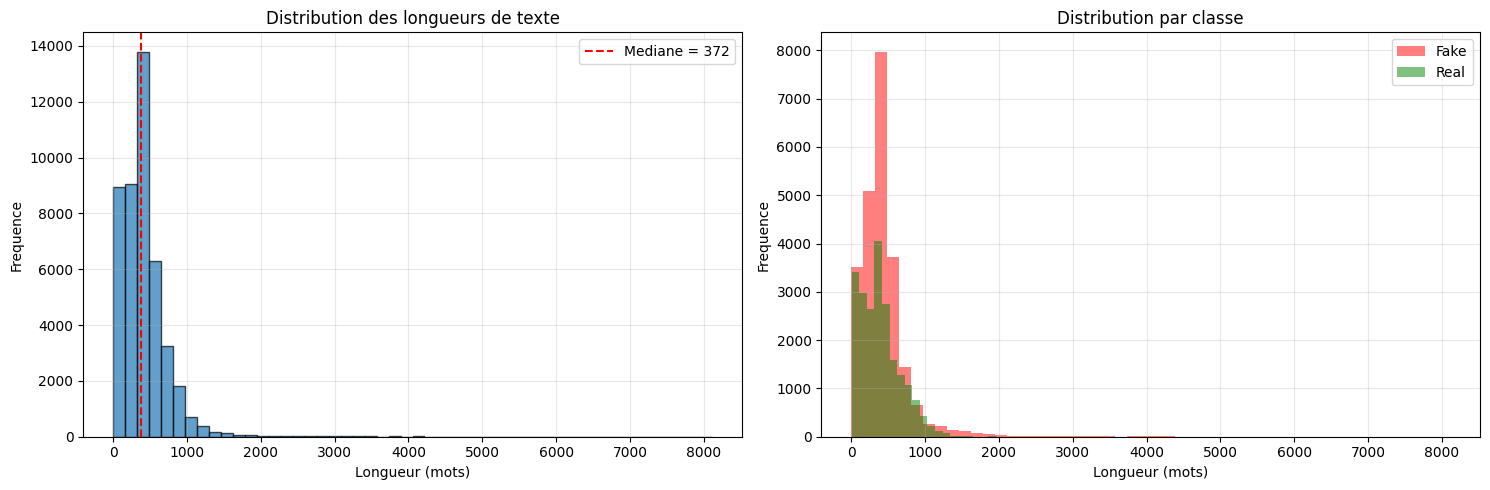

In [ ]:
# Visualisation des longueurs
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution globale
axes[0].hist(df['text_length_words'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Longueur (mots)')
axes[0].set_ylabel('Frequence')
axes[0].set_title('Distribution des longueurs de texte')
axes[0].axvline(df['text_length_words'].median(), color='red', linestyle='--', label=f'Mediane = {df["text_length_words"].median():.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Par classe
df[df['label'] == 0]['text_length_words'].hist(bins=50, alpha=0.5, label='Fake', ax=axes[1], color='red')
df[df['label'] == 1]['text_length_words'].hist(bins=50, alpha=0.5, label='Real', ax=axes[1], color='green')
axes[1].set_xlabel('Longueur (mots)')
axes[1].set_ylabel('Frequence')
axes[1].set_title('Distribution par classe')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Nettoyage : suppression textes vides et doublons
print("Nettoyage des donnees...")

initial_count = len(df)

# Suppression textes vides
df = df[df['processed_text'].str.strip() != '']
print(f"   Textes vides supprimes : {initial_count - len(df)}")

# Suppression doublons (sur le texte preprocesse)
initial_count = len(df)
df = df.drop_duplicates(subset=['processed_text'], keep='first')
print(f"   Doublons supprimes : {initial_count - len(df)}")

print(f"\nDataset final : {len(df):,} articles")
print(f"\nDistribution finale :")
print(df['label'].value_counts())
print(f"Ratio Fake/Real : {df['label'].value_counts()[0] / df['label'].value_counts()[1]:.2f}")

Nettoyage des donnees...
   Textes vides supprimes : 9
   Doublons supprimes : 5794

Dataset final : 39,095 articles

Distribution finale :
label
1    21195
0    17900
Name: count, dtype: int64
Ratio Fake/Real : 0.84


---

## Section 4 : Split Train/Validation/Test

Strategie identique a votre equipe :
- 64% Train
- 16% Validation
- 20% Test

Stratification pour garder le meme ratio fake/real dans chaque set.

In [ ]:
# Preparation des donnees
X = df['processed_text'].values
y = df['label'].values

# Split 1 : 80% train+val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# Split 2 : 80% train, 20% val (du train+val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.20,
    random_state=42,
    stratify=y_train_val
)

print("Split du dataset :")
print(f"   Train      : {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"   Validation : {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"   Test       : {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

# Verification stratification
print("\nVerification stratification :")
print(f"   Train - Fake : {(y_train == 0).sum()} | Real : {(y_train == 1).sum()}")
print(f"   Val   - Fake : {(y_val == 0).sum()} | Real : {(y_val == 1).sum()}")
print(f"   Test  - Fake : {(y_test == 0).sum()} | Real : {(y_test == 1).sum()}")

Split du dataset :
   Train      : 25,020 samples (64.0%)
   Validation : 6,256 samples (16.0%)
   Test       : 7,819 samples (20.0%)

Verification stratification :
   Train - Fake : 11456 | Real : 13564
   Val   - Fake : 2864 | Real : 3392
   Test  - Fake : 3580 | Real : 4239


---

## Section 5 : Tokenization et Sequences

Conversion du texte en sequences d'indices numeriques.

In [ ]:
# HYPERPARAMETRES
VOCAB_SIZE = 20000           # 20k mots les plus frequents
MAX_SEQUENCE_LENGTH = 500    # Longueur max en tokens
EMBEDDING_DIM = 300          # Dimension Word2Vec

print("Hyperparametres de tokenization :")
print(f"   Vocab size : {VOCAB_SIZE:,}")
print(f"   Max sequence length : {MAX_SEQUENCE_LENGTH}")
print(f"   Embedding dimension : {EMBEDDING_DIM}")

Hyperparametres de tokenization :
   Vocab size : 20,000
   Max sequence length : 500
   Embedding dimension : 300


In [ ]:
# Creation du Tokenizer
print("Creation du tokenizer...")

tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    oov_token='<OOV>',
    lower=False,  # Deja en minuscules
    filters=''    # IMPORTANT : On ne filtre RIEN (on garde la ponctuation !)
)

# Fit sur train uniquement
tokenizer.fit_on_texts(X_train)

print(f"\nTokenizer cree !")
print(f"   Vocabulaire total : {len(tokenizer.word_index):,} mots uniques")
print(f"   Vocabulaire utilise : {VOCAB_SIZE:,} mots")

# Top 30 mots (on voit maintenant la ponctuation !)
print("\nTop 30 mots les plus frequents (avec ponctuation) :")
word_freq = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:30]
for word, freq in word_freq:
    print(f"   '{word}': {freq:,}")

Creation du tokenizer...

Tokenizer cree !
   Vocabulaire total : 260,735 mots uniques
   Vocabulaire utilise : 20,000 mots

Top 30 mots les plus frequents (avec ponctuation) :
   'the': 547,160
   'to': 301,568
   'of': 242,213
   'a': 225,929
   'and': 220,733
   'in': 192,468
   'that': 125,758
   'on': 109,739
   'for': 96,921
   's': 90,267
   'is': 89,202
   'he': 74,008
   'with': 65,833
   'trump': 65,641
   'it': 62,029
   'was': 61,397
   'as': 56,974
   'said': 55,442
   'his': 54,667
   'by': 52,198
   'has': 49,947
   'be': 45,842
   'have': 45,577
   'from': 44,531
   'not': 44,476
   'at': 40,841
   'are': 38,836
   'who': 37,812
   'this': 36,931
   'an': 36,855


Conversion des textes en sequences...
Sequences creees !

Statistiques de longueur :
   Moyenne : 407 tokens
   Mediane : 375 tokens
   Max : 8110 tokens


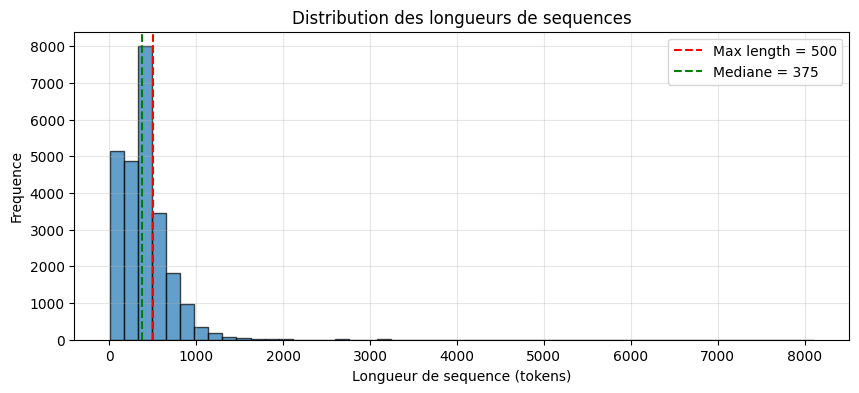


Sequences tronquees : 6,756 (27.0%)


In [ ]:
# Conversion texte -> sequences
print("Conversion des textes en sequences...")

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print("Sequences creees !")

# Statistiques
seq_lengths = [len(seq) for seq in X_train_seq]
print(f"\nStatistiques de longueur :")
print(f"   Moyenne : {np.mean(seq_lengths):.0f} tokens")
print(f"   Mediane : {np.median(seq_lengths):.0f} tokens")
print(f"   Max : {np.max(seq_lengths)} tokens")

# Visualisation
plt.figure(figsize=(10, 4))
plt.hist(seq_lengths, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(MAX_SEQUENCE_LENGTH, color='red', linestyle='--', label=f'Max length = {MAX_SEQUENCE_LENGTH}')
plt.axvline(np.median(seq_lengths), color='green', linestyle='--', label=f'Mediane = {np.median(seq_lengths):.0f}')
plt.xlabel('Longueur de sequence (tokens)')
plt.ylabel('Frequence')
plt.title('Distribution des longueurs de sequences')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

truncated = sum(1 for length in seq_lengths if length > MAX_SEQUENCE_LENGTH)
print(f"\nSequences tronquees : {truncated:,} ({truncated/len(seq_lengths)*100:.1f}%)")

### Évaluation du Choix de MAX_SEQUENCE_LENGTH = 500

Le choix d’une longueur maximale de 500 tokens conduit à la troncature d’environ 27 % des articles.

In [ ]:
# Padding
print("Padding des sequences...")

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("Padding termine !")
print(f"   X_train_pad : {X_train_pad.shape}")
print(f"   X_val_pad   : {X_val_pad.shape}")
print(f"   X_test_pad  : {X_test_pad.shape}")

Padding des sequences...
Padding termine !
   X_train_pad : (25020, 500)
   X_val_pad   : (6256, 500)
   X_test_pad  : (7819, 500)


---

## Section 6 : Word2Vec et Embedding Matrix

In [ ]:
# Telechargement Word2Vec (2GB, 5-10 min)
print("Telechargement Word2Vec Google News (300d)...")
print("Cela peut prendre 5-10 minutes la premiere fois...")

try:
    word2vec = api.load('word2vec-google-news-300')
    print("\nWord2Vec charge avec succes !")
    print(f"   Vocabulaire : {len(word2vec):,} vecteurs")
    print(f"   Dimensions : {word2vec.vector_size}")
except Exception as e:
    print(f"Erreur : {e}")
    print("\nSolution : telecharger manuellement et charger avec KeyedVectors")

Telechargement Word2Vec Google News (300d)...
Cela peut prendre 5-10 minutes la premiere fois...
[==================================================] 100.0% 1662.8/1662.8MB downloaded

Word2Vec charge avec succes !
   Vocabulaire : 3,000,000 vecteurs
   Dimensions : 300


In [ ]:
# Creation de la matrice d'embeddings
print("Creation de la matrice d'embeddings...")

embedding_matrix = np.zeros((VOCAB_SIZE + 1, EMBEDDING_DIM))
found = 0
not_found = 0

for word, idx in tokenizer.word_index.items():
    if idx >= VOCAB_SIZE:
        break

    if word in word2vec:
        embedding_matrix[idx] = word2vec[word]
        found += 1
    else:
        embedding_matrix[idx] = np.random.normal(0, 0.01, EMBEDDING_DIM)
        not_found += 1

print("\nMatrice d'embeddings creee !")
print(f"   Shape : {embedding_matrix.shape}")
print(f"   Mots trouves : {found:,} ({found/(found+not_found)*100:.1f}%)")
print(f"   Mots NON trouves : {not_found:,} ({not_found/(found+not_found)*100:.1f}%)")

Creation de la matrice d'embeddings...

Matrice d'embeddings creee !
   Shape : (20001, 300)
   Mots trouves : 12,660 (63.3%)
   Mots NON trouves : 7,339 (36.7%)


### Analyse de la Couverture Word2Vec

Environ 63 % du vocabulaire est couvert par les embeddings pré-entraînés Word2Vec.

---

## Section 7 : Construction du Modele BiLSTM

In [ ]:
# Hyperparametres
LSTM_UNITS = 128
DROPOUT_RATE = 0.5
SPATIAL_DROPOUT = 0.2
DENSE_UNITS = 64
LEARNING_RATE = 0.001

print("Hyperparametres du modele :")
print(f"   LSTM units : {LSTM_UNITS}")
print(f"   Dropout : {DROPOUT_RATE}")
print(f"   Spatial dropout : {SPATIAL_DROPOUT}")
print(f"   Dense units : {DENSE_UNITS}")
print(f"   Learning rate : {LEARNING_RATE}")

Hyperparametres du modele :
   LSTM units : 128
   Dropout : 0.5
   Spatial dropout : 0.2
   Dense units : 64
   Learning rate : 0.001


In [ ]:
# Construction du modele
def build_bilstm_model():
    model = Sequential([
        Embedding(
            input_dim=VOCAB_SIZE + 1,
            output_dim=EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=True,
            name='embedding'
        ),
        SpatialDropout1D(SPATIAL_DROPOUT, name='spatial_dropout'),
        Bidirectional(LSTM(LSTM_UNITS, return_sequences=False, name='lstm'), name='bidirectional_lstm'),
        Dropout(DROPOUT_RATE, name='dropout_1'),
        Dense(DENSE_UNITS, activation='relu', name='dense_1'),
        Dropout(0.3, name='dropout_2'),
        Dense(1, activation='sigmoid', name='output')
    ], name='BiLSTM')
    return model

print("Construction du modele...")
model = build_bilstm_model()

model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))


print("\nModele construit !")
model.summary()

Construction du modele...

Modele construit !


Model: "BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 300)       │     6,000,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout                 │ (None, 500, 300)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 256)            │       439,296 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,456,109 (24.63 MB)

 Trainable params: 6,456,109 (24.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilation
print("Compilation du modele...")

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

print("Modele compile !")

Compilation du modele...
Modele compile !


---

## Section 8 : Entrainement

In [ ]:
# Hyperparametres entrainement
BATCH_SIZE = 64
EPOCHS = 10

print(f"Batch size : {BATCH_SIZE}")
print(f"Max epochs : {EPOCHS}")

Batch size : 64
Max epochs : 10


In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_bilstm_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-7, verbose=1)

callbacks = [early_stop, checkpoint, reduce_lr]
print("Callbacks definis.")

Callbacks definis.


In [ ]:
# Entrainement
print("Debut de l'entrainement...\n")
print("=" * 80)

history = model.fit(
    X_train_pad, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_pad, y_val),
    callbacks=callbacks,
    verbose=1
)

print("\n" + "=" * 80)
print("Entrainement termine !")

Debut de l'entrainement...

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9257 - auc: 0.9687 - loss: 0.1559 - precision: 0.9168 - recall: 0.9557
Epoch 1: val_accuracy improved from -inf to 0.99840, saving model to best_bilstm_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.9259 - auc: 0.9688 - loss: 0.1557 - precision: 0.9169 - recall: 0.9558 - val_accuracy: 0.9984 - val_auc: 0.9994 - val_loss: 0.0079 - val_precision: 1.0000 - val_recall: 0.9971 - learning_rate: 0.0010
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9995 - auc: 0.9998 - loss: 0.0035 - precision: 0.9999 - recall: 0.9991
Epoch 2: val_accuracy improved from 0.99840 to 0.99920, saving model to best_bilstm_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - accuracy: 0.9995 - auc: 0.9998 - loss: 0.0035 - precision: 0.9999 - recall: 0.9991 - val_accuracy: 0.9992 - val_auc: 0.9997 - val_loss: 0.0043 - val_precision: 1.0000 - val_recall: 0.9985 - learning_rate: 0.0010
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 5.3574e-04 - precision: 0.9999 - recall: 0.9998
Epoch 3: val_accuracy improved from 0.99920 to 0.99952, saving model to best_bilstm_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 5.3645e-04 - precision: 0.9999 - recall: 0.9998 - val_accuracy: 0.9995 - val_auc: 0.9997 - val_loss: 0.0036 - val_precision: 1.0000 - val_recall: 0.9991 - learning_rate: 0.0010
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 1.7740e-04 - precision: 1.0000 - recall: 0.9999
Epoch 4: val_accuracy did not improve from 0.99952
391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - accuracy: 0.9999 - auc: 1.0000 - loss: 1.7751e-04 - precision: 1.0000 - recall: 0.9999 - val_accuracy: 0.9995 - val_auc: 0.9997 - val_loss: 0.0033 - val_precision: 1.0000 - val_recall: 0.9991 - learning_rate: 0.0010
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 3.7075e-05 - precision: 1.0000 - recall: 1.0000
Epoch 5: val_accuracy did not improve from 0.99952

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 ━━━━━━━

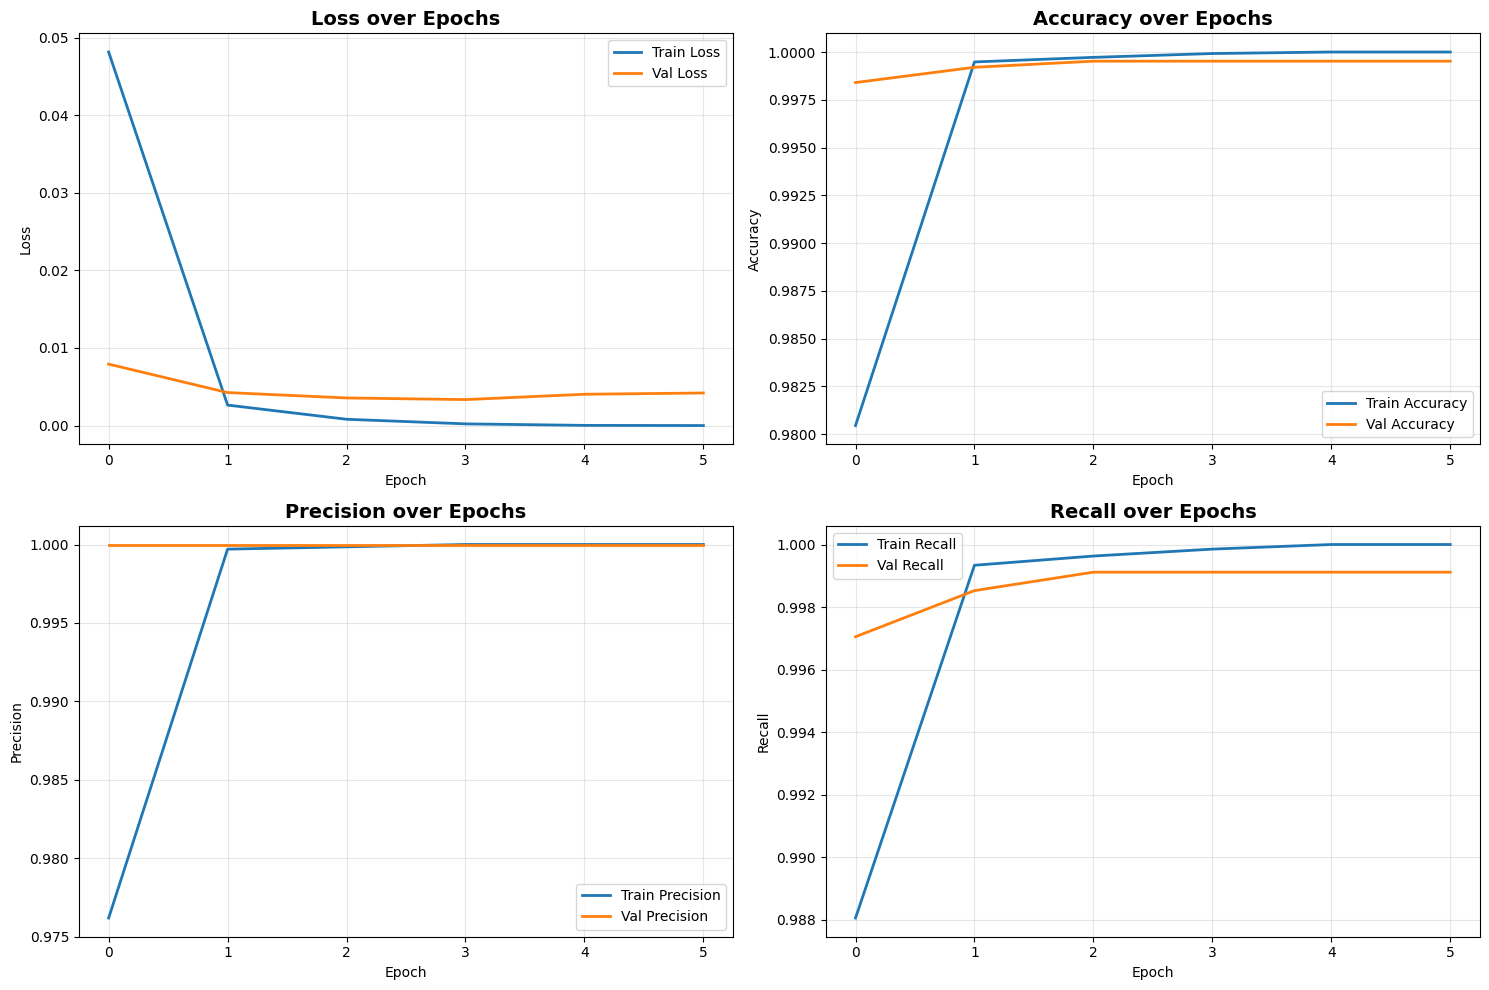

In [ ]:
# Visualisation courbes
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Loss over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Precision over Epochs', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_title('Recall over Epochs', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Diagnostic overfitting
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
gap = final_train_acc - final_val_acc

print("Resultats finaux :")
print(f"   Train Acc : {final_train_acc:.4f}")
print(f"   Val Acc   : {final_val_acc:.4f}")
print(f"   Gap       : {gap:.4f} ({gap*100:.2f}%)")

if gap > 0.05:
    print("\nOVERFITTING detecte")
elif gap < 0:
    print("\nBonne generalisation")
else:
    print("\nOptimal")

Resultats finaux :
   Train Acc : 1.0000
   Val Acc   : 0.9995
   Gap       : 0.0005 (0.05%)

Optimal


---

## Section 9 : Evaluation Test Set

In [ ]:
# Predictions
print("Predictions sur le test set...")

y_pred_proba = model.predict(X_test_pad, batch_size=BATCH_SIZE, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\nPredictions terminees !")

Predictions sur le test set...
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step

Predictions terminees !


In [ ]:
# Metriques
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print("\n" + "=" * 80)
print("RESULTATS FINAUX SUR TEST SET")
print("=" * 80)
print(f"\n   Accuracy  : {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision : {test_precision:.4f}")
print(f"   Recall    : {test_recall:.4f}")
print(f"   F1-Score  : {test_f1:.4f}")
print(f"   ROC-AUC   : {test_auc:.4f}")
print("\n" + "=" * 80)


RESULTATS FINAUX SUR TEST SET

   Accuracy  : 0.9992 (99.92%)
   Precision : 0.9995
   Recall    : 0.9991
   F1-Score  : 0.9993
   ROC-AUC   : 1.0000



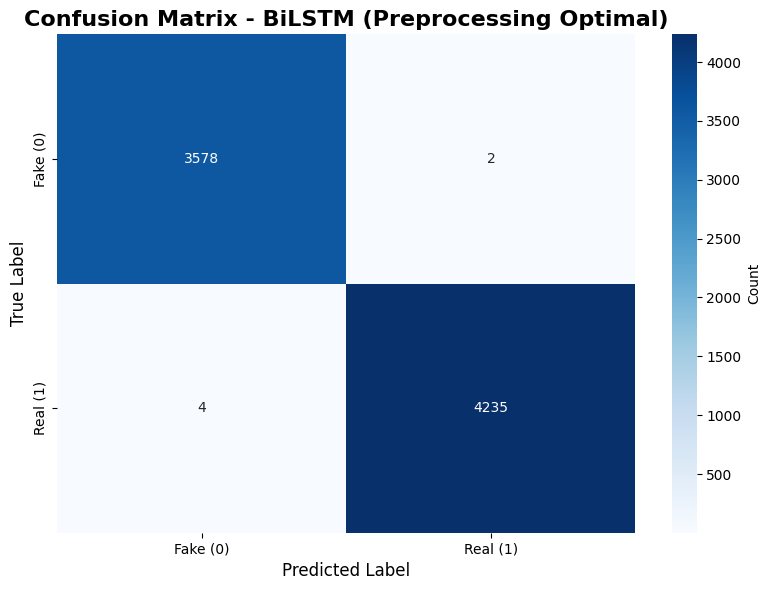


Details :
   TN : 3,578 | FP : 2
   FN : 4 | TP : 4,235


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake (0)', 'Real (1)'],
            yticklabels=['Fake (0)', 'Real (1)'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - BiLSTM (Preprocessing Optimal)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print("\nDetails :")
print(f"   TN : {tn:,} | FP : {fp:,}")
print(f"   FN : {fn:,} | TP : {tp:,}")

In [ ]:
# Classification Report
print("\nClassification Report :")
print(classification_report(y_test, y_pred, target_names=['Fake News', 'Real News'], digits=4))


Classification Report :
              precision    recall  f1-score   support

   Fake News     0.9989    0.9994    0.9992      3580
   Real News     0.9995    0.9991    0.9993      4239

    accuracy                         0.9992      7819
   macro avg     0.9992    0.9992    0.9992      7819
weighted avg     0.9992    0.9992    0.9992      7819



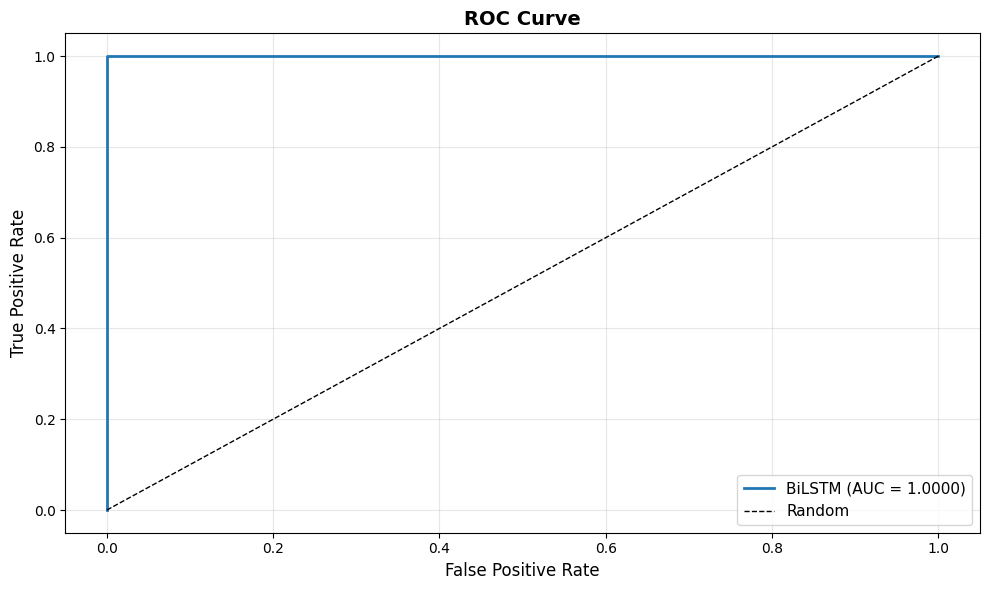

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'BiLSTM (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Section 10 : Analyse des Erreurs

In [ ]:
# Identification erreurs
fp_indices = np.where((y_test == 0) & (y_pred == 1))[0]
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0]

print("Analyse des erreurs :")
print(f"\n   False Positives : {len(fp_indices):,} ({len(fp_indices)/len(y_test)*100:.2f}%)")
print(f"   False Negatives : {len(fn_indices):,} ({len(fn_indices)/len(y_test)*100:.2f}%)")

Analyse des erreurs :

   False Positives : 2 (0.03%)
   False Negatives : 4 (0.05%)


In [ ]:
# Exemples False Positives
print("\n" + "=" * 80)
print("EXEMPLES FALSE POSITIVES (Fake -> Real)")
print("=" * 80)

for i, idx in enumerate(fp_indices[:3]):
    print(f"\nFP #{i+1} :")
    print(f"   True: FAKE | Pred: REAL | Proba: {y_pred_proba[idx][0]:.4f}")
    print(f"   Texte: {X_test[idx][:300]}...")
    print("   " + "-" * 76)


EXEMPLES FALSE POSITIVES (Fake -> Real)

FP #1 :
   True: FAKE | Pred: REAL | Proba: 0.9997
   Texte: breaking: senate strikes back after obama slaps / victim’s families in the face….vote - washington the house and senate wednesday voted to reject president obama s veto of legislation allowing lawsuits against foreign sponsors of terrorism in the first successful override of a presidential veto sinc...
   ----------------------------------------------------------------------------

FP #2 :
   True: FAKE | Pred: REAL | Proba: 0.6948
   Texte: voting machines stolen in controversial ga election where dems hope to embarrass trump with -yr old jon ossoff win sandy springs, ga., april (reuters) for u.s. president donald trump, an off-year congressional election on tuesday in the reliably republican northern suburbs of atlanta could spell tro...
   ----------------------------------------------------------------------------


In [ ]:
# Exemples False Negatives
print("\n" + "=" * 80)
print("EXEMPLES FALSE NEGATIVES (Real -> Fake)")
print("=" * 80)

for i, idx in enumerate(fn_indices[:3]):
    print(f"\nFN #{i+1} :")
    print(f"   True: REAL | Pred: FAKE | Proba: {y_pred_proba[idx][0]:.4f}")
    print(f"   Texte: {X_test[idx][:300]}...")
    print("   " + "-" * 76)


EXEMPLES FALSE NEGATIVES (Real -> Fake)

FN #1 :
   True: REAL | Pred: FAKE | Proba: 0.0012
   Texte: u.s. intelligence agencies feud with republicans over russian hacking republican members of congress are complaining that u.s. intelligence agencies are refusing to brief them widely on a classified cia report that concluded russia hacked democratic party data in an effort to help donald trump win t...
   ----------------------------------------------------------------------------

FN #2 :
   True: REAL | Pred: FAKE | Proba: 0.0001
   Texte: commentary: party leaders often disliked their nominee. it’s the public vitriol that’s new. gop leaders have unleashed a stunning level of vitriol against their party’s most successful presidential candidate. house speaker paul ryan (r-wis.), emphatically declared last week that he was not ready to ...
   ----------------------------------------------------------------------------

FN #3 :
   True: REAL | Pred: FAKE | Proba: 0.0000
   Texte: jenne

---

## Section 11 : Explainability avec LIME

In [ ]:
# Configuration LIME
def predict_proba_lime(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
    preds = model.predict(padded, verbose=0)
    return np.hstack([1 - preds, preds])

explainer = LimeTextExplainer(class_names=['Fake News', 'Real News'], bow=False)
print("LIME configure.")

LIME configure.


In [ ]:
# Explication True Positive
tp_indices = np.where((y_test == 1) & (y_pred == 1))[0]
idx = tp_indices[0]

print("\n" + "=" * 80)
print("EXPLICATION LIME - TRUE POSITIVE")
print("=" * 80)
print(f"\n   True: REAL | Pred: REAL | Proba: {y_pred_proba[idx][0]:.4f}")
print(f"\n   Texte: {X_test[idx][:200]}...")
print("\nGeneration explication (30-60 sec)...")

exp = explainer.explain_instance(X_test[idx], predict_proba_lime, num_features=10, num_samples=1000)

print("\nMots influents :")
for word, weight in exp.as_list():
    direction = "-> Real" if weight > 0 else "-> Fake"
    print(f"   '{word}': {weight:+.4f} {direction}")

exp.show_in_notebook(text=True)


EXPLICATION LIME - TRUE POSITIVE

   True: REAL | Pred: REAL | Proba: 1.0000

   Texte: democrats expect senate will oppose obama on saudi / bill washington (reuters) - the democratic leaders of the u.s. senate said on tuesday they expected the chamber would vote to override president ba...

Generation explication (30-60 sec)...

Mots influents :
   'washington': +0.0001 -> Real
   'reuters': +0.0001 -> Real
   'bill': -0.0000 -> Fake
   'obama': -0.0000 -> Fake
   'were': +0.0000 -> Real
   'expected': +0.0000 -> Real
   'senate': -0.0000 -> Fake
   'sept': +0.0000 -> Real
   'democratic': -0.0000 -> Fake
   'his': +0.0000 -> Real


In [ ]:
# Explication False Positive
if len(fp_indices) > 0:
    idx = fp_indices[0]

    print("\n" + "=" * 80)
    print("EXPLICATION LIME - FALSE POSITIVE")
    print("=" * 80)
    print(f"\n   True: FAKE | Pred: REAL | Proba: {y_pred_proba[idx][0]:.4f}")
    print(f"\n   Texte: {X_test[idx][:200]}...")
    print("\nGeneration explication...")

    exp = explainer.explain_instance(X_test[idx], predict_proba_lime, num_features=10, num_samples=1000)

    print("\nMots qui ont trompe le modele :")
    for word, weight in exp.as_list():
        direction = "-> Real" if weight > 0 else "-> Fake"
        print(f"   '{word}': {weight:+.4f} {direction}")

    exp.show_in_notebook(text=True)


EXPLICATION LIME - FALSE POSITIVE

   True: FAKE | Pred: REAL | Proba: 0.9997

   Texte: breaking: senate strikes back after obama slaps / victim’s families in the face….vote - washington the house and senate wednesday voted to reject president obama s veto of legislation allowing lawsuit...

Generation explication...

Mots qui ont trompe le modele :
   'washington': +0.6600 -> Real
   'families': -0.2618 -> Fake
   'infringe': -0.0689 -> Fake
   'back': -0.0567 -> Fake
   'the': -0.0546 -> Fake
   'd': +0.0231 -> Real
   'as': +0.0195 -> Real
   'wednesday': +0.0177 -> Real
   'soil': +0.0087 -> Real
   'to': -0.0017 -> Fake


---

## Section 12 : Sauvegarde

In [ ]:
import pickle
import json

model.save('bilstm_optimal_preprocessing.h5')
print("Modele sauvegarde : bilstm_optimal_preprocessing.h5")

with open('tokenizer_optimal.pickle', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer sauvegarde : tokenizer_optimal.pickle")

with open('history_optimal.json', 'w') as f:
    json.dump(history.history, f)
print("Historique sauvegarde : history_optimal.json")

Modele sauvegarde : bilstm_optimal_preprocessing.h5
Tokenizer sauvegarde : tokenizer_optimal.pickle
Historique sauvegarde : history_optimal.json


In [ ]:
import pickle
import json
import os

# Dossier de sauvegarde
SAVE_DIR = "/content/drive/My Drive/bilstm_fakenews_api"

# Création du dossier s'il n'existe pas
os.makedirs(SAVE_DIR, exist_ok=True)

#  Sauvegarde du modèle (FORMAT RECOMMANDÉ API)
model_path = os.path.join(SAVE_DIR, "bilstm_optimal_preprocessing.keras")
model.save(model_path)
print(f" Modèle sauvegardé : {model_path}")

#  Sauvegarde du tokenizer
tokenizer_path = os.path.join(SAVE_DIR, "tokenizer_optimal.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f" Tokenizer sauvegardé : {tokenizer_path}")

#  Sauvegarde de l'historique d'entraînement
history_path = os.path.join(SAVE_DIR, "history_optimal.json")
with open(history_path, "w") as f:
    json.dump(history.history, f)
print(f" Historique sauvegardé : {history_path}")


 Modèle sauvegardé : /content/drive/My Drive/bilstm_fakenews_api/bilstm_optimal_preprocessing.keras
 Tokenizer sauvegardé : /content/drive/My Drive/bilstm_fakenews_api/tokenizer_optimal.pkl
 Historique sauvegardé : /content/drive/My Drive/bilstm_fakenews_api/history_optimal.json
